In [1]:
# imports and stuff
from pyqg import qg_model, particles
import time
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# setup model
year = 24*60*60*360.
m =  qg_model.QGModel(tavestart=np.inf,
                      nx=64, dt=8000, tmax=4.01*year)

In [7]:
# set up lagrangian particles

x0,y0 = np.meshgrid(m.x[0,::1], m.y[::1,0])
x0 = x0.ravel()
y0 = y0.ravel()
Npart = x0.size

lpa = particles.GriddedLagrangianParticleArray2D(x0, y0, m.nx, m.ny,
        periodic_in_x=True, periodic_in_y=True,
        xmin=0, xmax=m.L, ymin=0, ymax=m.W)

# number of particles to save
Nhold = 3
particle_history = np.zeros((Nhold,2,Npart))


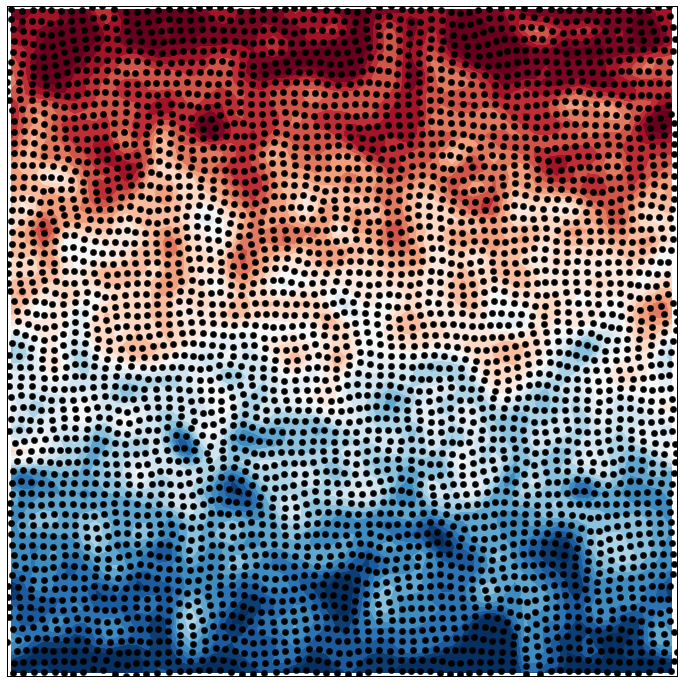

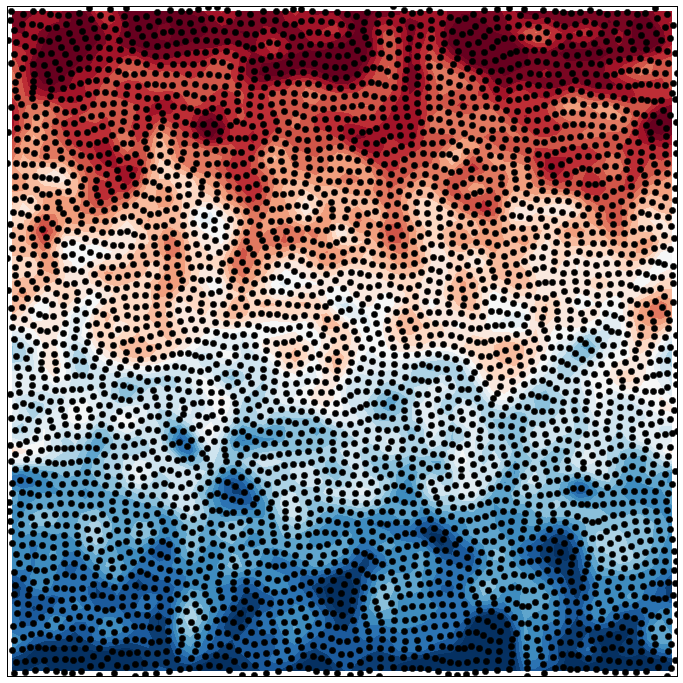

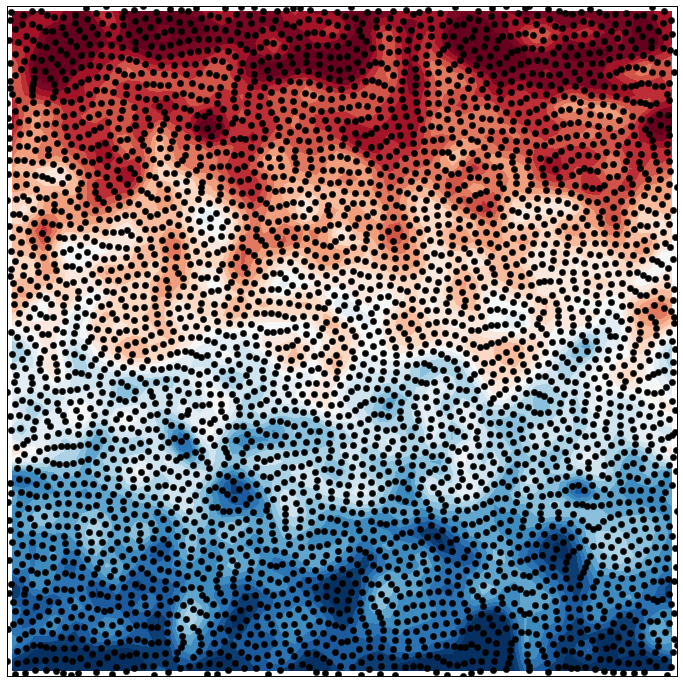

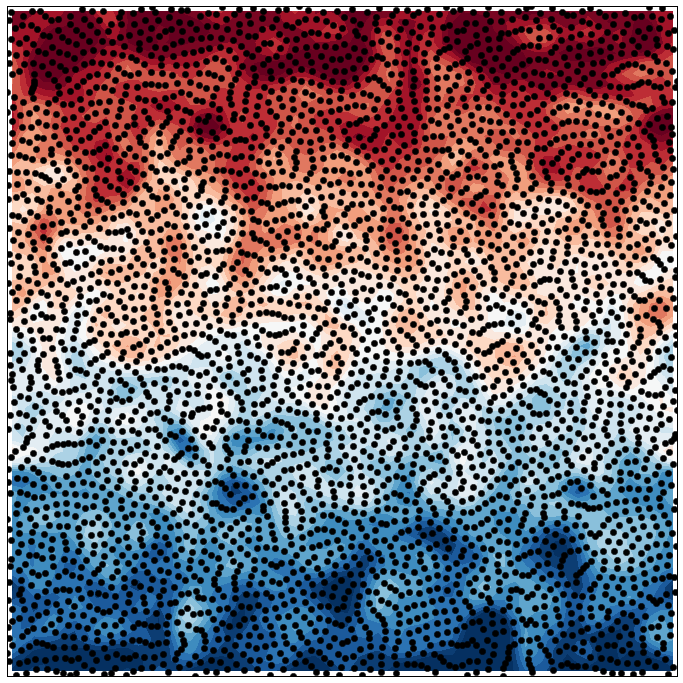

In [19]:
# hack to reset the timer
#m.tmax = 8.1*year
m.tmax = 4.01*year
if m.t > 4*year:
    m.t = 4*year

started_advecting = False
tprev = time.time()
n=0

# set up extended grid for lagrangian particles
x = np.hstack([m.x[0,0]-m.dx, m.x[0,:], m.x[0,-1]+m.dx])
y = np.hstack([m.y[0,0]-m.dy, m.y[:,0], m.y[-1,0]+m.dy])
for snapshot in m.run_with_snapshots(
        tsnapstart=4*year, tsnapint=m.dt):

    if n==0:
        qi = m.q[0].copy()
        ui = m.u[0].copy()
        vi = m.v[0].copy() 
    
    # set up velocities for lagrangian advection
    # need a view with wrapped values
    u = m.u[0][np.r_[-1,0:m.ny,0]][:,np.r_[-1,0:m.nx,0]]
    v = m.v[0][np.r_[-1,0:m.ny,0]][:,np.r_[-1,0:m.nx,0]]

    if started_advecting:
        lpa.step_forward_with_gridded_uv(
            uprev, vprev, u, v, m.dt)
        particle_history = np.roll(
            particle_history, 1, axis=0
        )
        particle_history[0,0,:] = lpa.x
        particle_history[0,1,:] = lpa.y
        n+=1
    
    uprev = u.copy()
    vprev = v.copy()
    started_advecting = True
    
    # plots
    if n%10==1:
        fig=plt.figure(figsize=(12,12))
        ax = plt.subplot(111)
        plt.contourf(m.x, m.y,
            m.q[0] + m.Qy1*m.y, np.linspace(0,1,20)*1*m.Qy1*m.W,
            extend='both', cmap='RdBu_r')
        #quiver(m.x,m.y,m.u[0],m.v[0], scale=10)
        #plot(particle_history[-1,0,:].ravel(),
        #         particle_history[-1,1,:].ravel(), 'o', color='0.5') 
        plt.plot(particle_history[0,0,:].ravel(),
                 particle_history[0,1,:].ravel(), 'ko')
        #plot(x0.ravel(), y0.ravel(), 'ro')
        ax.set_xticks([])
        ax.set_yticks([])
    
    if n>50:
        break

# now the model is done    

